In [33]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer, AutoTokenizer, DataCollatorForTokenClassification
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import PCA
from umap import UMAP
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import auxiliary as aux
from kingbert import KingBert
import os
from adjustText import adjust_text
from matplotlib import cm, colors
from matplotlib.lines import Line2D
import auxiliary as aux            

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using:", device)         


all_labels = ['B-STREET',
 'B-CITY',
 'I-DATE',
 'B-PASS',
 'I-CITY',
 'B-TIME',
 'B-EMAIL',
 'I-DRIVERLICENSE',
 'I-POSTCODE',
 'I-BOD',
 'B-USERNAME',
 'B-BOD',
 'B-COUNTRY',
 'B-SECADDRESS',
 'B-IDCARD',
 'I-SOCIALNUMBER',
 'I-PASSPORT',
 'B-IP',
 'O',
 'B-TEL',
 'B-SOCIALNUMBER',
 'I-TIME',
 'B-BUILDING',
 'B-PASSPORT',
 'I-TITLE',
 'I-SEX',
 'I-STREET',
 'B-STATE',
 'I-STATE',
 'B-TITLE',
 'B-DATE',
 'B-GEOCOORD',
 'I-IDCARD',
 'I-TEL',
 'B-POSTCODE',
 'B-DRIVERLICENSE',
 'I-GEOCOORD',
 'I-COUNTRY',
 'I-EMAIL',
 'I-PASS',
 'B-SEX',
 'I-USERNAME',
 'I-BUILDING',
 'I-IP',
 'I-SECADDRESS',
 'B-CARDISSUER',
 'I-CARDISSUER']
id2label = {i: l for i, l in enumerate(all_labels)}
label2id = {v: k for k, v in id2label.items()}
target = [l for l in all_labels if l != "O"]


Using: cuda:0


In [46]:
def extract_distilbert_embeddings(model, tokenizer, sentence):
    """Extract raw token embeddings from DistilBERT encoder before classification."""
    model.eval()

    # Tokenize input
    inputs = tokenizer.tokenize(sentence)
    input_ids = torch.tensor([[101] + tokenizer.convert_tokens_to_ids(inputs) + [102]])
    attention_mask = torch.tensor([1 for i in range(len(input_ids))]).unsqueeze(0)

    # Send to same device as model
    device = next(model.parameters()).device
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    # Get token-level embeddings from the encoder (before classifier)
    with torch.no_grad():
        outputs = model.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state  # shape: (1, seq_len, hidden_dim)

    return hidden_states.squeeze(0).cpu(), tokenizer.convert_ids_to_tokens(input_ids.squeeze(0).tolist())


def extract_albert_embeddings(model, tokenizer, sentence):
    """Extract raw token embeddings from DistilBERT encoder before classification."""
    model.eval()

    # Tokenize input
    inputs = tokenizer.tokenize(sentence)
    input_ids = torch.tensor([[101] + tokenizer.convert_tokens_to_ids(inputs) + [102]])
    attention_mask = torch.tensor([1 for i in range(len(input_ids))]).unsqueeze(0)

    # Send to same device as model
    device = next(model.parameters()).device
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    # Get token-level embeddings from the encoder (before classifier)
    with torch.no_grad():
        outputs = model.albert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state  # shape: (1, seq_len, hidden_dim)

    return hidden_states.squeeze(0).cpu(), tokenizer.convert_ids_to_tokens(input_ids.squeeze(0).tolist())


def build_palette(labels):
    """
    Return dict: label_id -> hex colour.
    Uses 3 qualitative colormaps concatenated to get 60 different hues.
    """
    cmaps = [cm.get_cmap(name, 20) for name in ("tab20", "tab20b", "tab20c")]
    big   = np.vstack([m(np.arange(20))[:, :3] for m in cmaps])  # (60,3) RGB
    return {i: colors.rgb2hex(big[i]) for i in range(len(labels))}


def visualize_embeddings_2d(
        embeddings,                 # (n_tokens, hidden)
        tokens,                     # list[str]
        token_labels,               # list[int]  same length, BIO id per token
        id2label,                   # dict[int->str]
        method="umap", figsize=(14, 10), dpi=100,
        palette=None,               # dict[label_id]->colour
        show_labels=False,          # text on each dot?
        use_adjusttext=False,       # ignored if show_labels False
        legend=True                 # show full legend?
    ):
    """
    Plot 2-D projection of token embeddings, coloured by BIO label.
    """

    assert len(embeddings) == len(tokens) == len(token_labels)

    # ---------------------------------------------------------------- 1. reduce
    if method == "pca":
        reducer = PCA(n_components=2, random_state=0)
    elif method == "tsne":
        reducer = TSNE(n_components=2, perplexity=5,
                       learning_rate=10, random_state=0)
    else:
        reducer = UMAP(n_neighbors=5, min_dist=.3, random_state=0)

    reduced = reducer.fit_transform(embeddings)
    xs, ys  = reduced[:, 0], reduced[:, 1]

    # ---------------------------------------------------------------- 2. colours
    if palette is None:
        palette = build_palette(id2label)      # 47 distinct hues
    colours = [palette[lbl] for lbl in token_labels]

    # ---------------------------------------------------------------- 3. draw
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ax.scatter(xs, ys, c=colours, s=30, alpha=.85)

    if show_labels:
        texts = [ax.text(x, y, t, fontsize=9)
                 for x, y, t in zip(xs, ys, tokens)]
        if use_adjusttext:
            from adjustText import adjust_text
            adjust_text(texts, arrowprops=dict(arrowstyle='-',
                                               color='grey', lw=.5))

    ax.set_title(f"Token Embeddings ({method.upper()})")
    ax.axis("off")

    # ---------------------------------------------------------------- 4. legend
    if legend:
        handles = []
        for lbl_id, colour in palette.items():
            if lbl_id in token_labels:             # keep legend short if you down-sampled
                handles.append(Line2D([0], [0], marker='o', ls='',
                                      markerfacecolor=colour,
                                      markeredgecolor='none',
                                      markersize=6,
                                      label=id2label[lbl_id]))
        # put legend outside right edge
        ax.legend(handles=handles, frameon=False,
                  bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)

    plt.tight_layout()
    plt.show()


In [35]:
test_sentence = "My name is Cubo Mancini and my credit card is 4111-1111-1111-1111."

distilbert1 = AutoModelForTokenClassification.from_pretrained('to_share/distilbert1')
tokenizer_distilbert1  = AutoTokenizer.from_pretrained('to_share/distilbert1')

distilbert2 = AutoModelForTokenClassification.from_pretrained('to_share/distilbert2')
tokenizer_distilbert2  = AutoTokenizer.from_pretrained('to_share/distilbert2')

albert1 = AutoModelForTokenClassification.from_pretrained('to_share/albert1')
tokenizer_albert1  = AutoTokenizer.from_pretrained('to_share/albert1')

# Distilbert1

C:\Users\samue\AppData\Local\Temp\ipykernel_9860\1226622395.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmaps = [cm.get_cmap(name, 20) for name in ("tab20", "tab20b", "tab20c")]


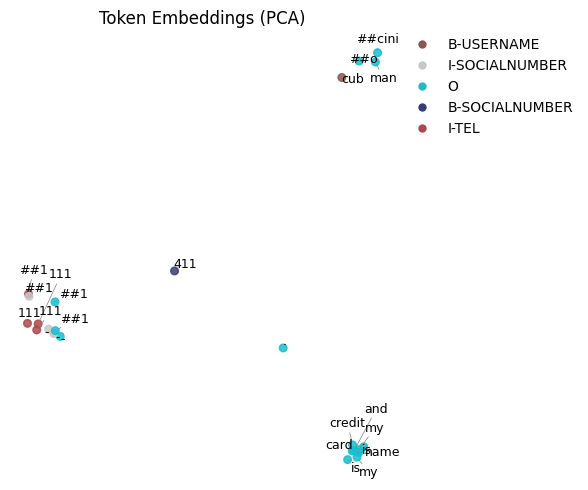

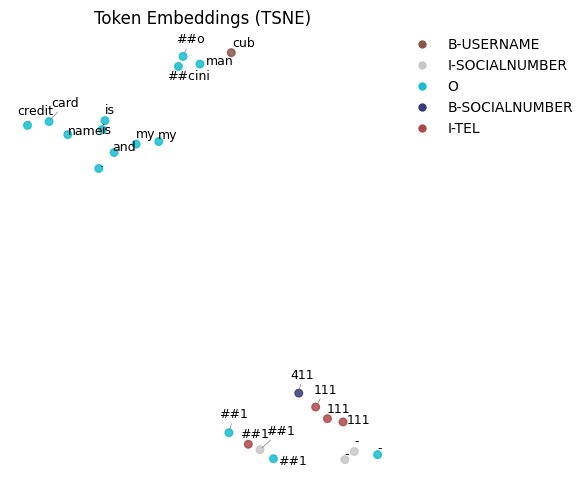

c:\Users\samue\Desktop\nlp-project\cubo_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\samue\Desktop\nlp-project\cubo_env\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


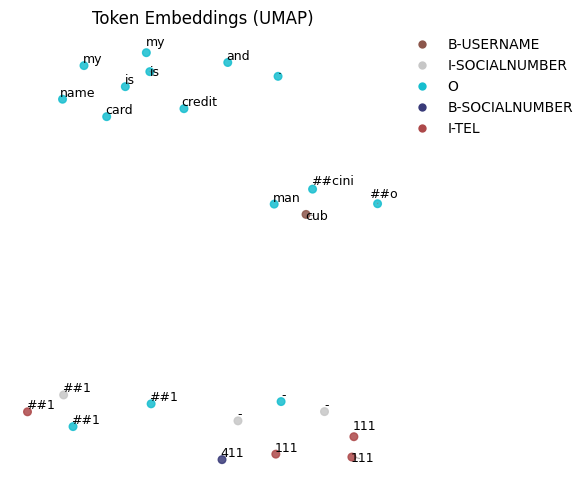

In [22]:
hidden_states, tokens = extract_distilbert_embeddings(distilbert1, tokenizer_distilbert1, test_sentence)
filtered_tok, filtered_emb, filtered_lbl = [], [], []   # we’ll fill lbl below
special = {tokenizer_distilbert1.cls_token, tokenizer_distilbert1.sep_token, tokenizer_distilbert1.pad_token}

for i, tok in enumerate(tokens):
    if tok in special:
        continue
    filtered_tok.append(tok)
    filtered_emb.append(hidden_states[i].cpu().numpy())

# ---------------------------------------------------------------------------------
# 2.  Predicted BIO label for each token (classification head)
# ---------------------------------------------------------------------------------
# Note: we reuse the *same* input_ids we just built inside extract_distilbert_embeddings
inputs       = tokenizer_distilbert1(test_sentence, return_tensors="pt")
inputs       = {k: v.to(distilbert1.device) for k, v in inputs.items()}

with torch.no_grad():
    logits   = distilbert1(**inputs).logits             # (1, seq_len, n_labels)
    preds    = logits.argmax(-1).squeeze(0)       # (seq_len,)

# Filter the predictions to line up with `filtered_tok`
for i, tok in enumerate(tokens):
    if tok in special:
        continue
    filtered_lbl.append(preds[i].item())          # int label id

# ---------------------------------------------------------------------------------
# 3.  Visualise
# ---------------------------------------------------------------------------------
palette = build_palette(aux.id2label)             # 47-colour palette

visualize_embeddings_2d(
    embeddings     = np.vstack(filtered_emb),     # (n_tokens, 768)
    tokens         = filtered_tok,                # list[str]
    token_labels   = filtered_lbl,                # list[int]
    id2label       = aux.id2label,                # dict[int->str]
    palette        = palette,
    method         = "pca",                       # or "umap"/"tsne"
    show_labels    = True,                        # small sentence → safe
    use_adjusttext = True,                        # keeps text readable
    legend         = True,
    figsize=(6,5)
)

visualize_embeddings_2d(
    embeddings     = np.vstack(filtered_emb),     # (n_tokens, 768)
    tokens         = filtered_tok,                # list[str]
    token_labels   = filtered_lbl,                # list[int]
    id2label       = aux.id2label,                # dict[int->str]
    palette        = palette,
    method         = "tsne",                       # or "umap"/"tsne"
    show_labels    = True,                        # small sentence → safe
    use_adjusttext = True,                        # keeps text readable
    legend         = True,
    figsize=(6,5)
)

visualize_embeddings_2d(
    embeddings     = np.vstack(filtered_emb),     # (n_tokens, 768)
    tokens         = filtered_tok,                # list[str]
    token_labels   = filtered_lbl,                # list[int]
    id2label       = aux.id2label,                # dict[int->str]
    palette        = palette,
    method         = "umap",                       # or "umap"/"tsne"
    show_labels    = True,                        # small sentence → safe
    use_adjusttext = True,                        # keeps text readable
    legend         = True,
    figsize=(6,5)
)

In [5]:
train_json = "data/distilbert_train.json"        
test_json = "data/distilbert_test.json"          
dataset    = aux.json_to_Dataset(train_json)
test_dataset    = aux.json_to_Dataset(test_json)

model_name = "to_share/distilbert1"
model      = AutoModelForTokenClassification.from_pretrained(model_name).to(device).eval()
tokenizer  = AutoTokenizer.from_pretrained(model_name)

In [6]:
# Collator that pads numeric tensors but leaves ragged lists intact

def collate_tok_clf(batch, pad_to_multiple_of=None):
    """
    - Pads input_ids / attention_mask via the tokenizer.
    - Keeps 'tokens' and 'labels' as raw Python lists (ragged).
    """
    numeric = [
        {k: sample[k] for k in ("input_ids", "attention_mask")}
        for sample in batch
    ]

    padded = tokenizer.pad(
        numeric,
        padding="longest",
        return_tensors="pt",
        pad_to_multiple_of=pad_to_multiple_of
    )

    # attach the ragged fields unchanged
    padded["tokens"] = [sample["tokens"]  for sample in batch]
    padded["labels"] = [sample["labels"]  for sample in batch]
    return padded

loader = DataLoader(
    dataset,
    batch_size=32,                 # ↓ if you get CUDA-OOM
    shuffle=False,
    collate_fn=collate_tok_clf
)

# 4.  Harvest hidden-state vectors for every non-special token
all_tok, all_emb, all_lbl = [], [], []

with torch.no_grad():
    for batch in tqdm(loader, desc="Embedding → GPU"):
        ids  = batch["input_ids"].to(device)
        mask = batch["attention_mask"].to(device)

        # Forward through the *encoder* only
        h = model.distilbert(input_ids=ids, attention_mask=mask).last_hidden_state
        h = h.cpu().numpy()                       # move off-GPU right away

        for seq_idx, (toks, labs) in enumerate(zip(batch["tokens"], batch["labels"])):
            for pos, tok in enumerate(toks):
                if tok in {tokenizer.cls_token, tokenizer.sep_token, tokenizer.pad_token}:
                    continue
                all_tok.append(tok)
                all_emb.append(h[seq_idx, pos])
                all_lbl.append(labs[pos])

Embedding → GPU:   0%|          | 0/571 [00:00<?, ?it/s]You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
c:\Users\samue\Desktop\nlp-project\cubo_env\Lib\site-packages\transformers\models\distilbert\modeling_distilbert.py:401: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
Embedding → GPU: 100%|██████████| 571/571 [00:55<00:00, 10.24it/s]


C:\Users\samue\AppData\Local\Temp\ipykernel_9860\1226622395.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmaps = [cm.get_cmap(name, 20) for name in ("tab20", "tab20b", "tab20c")]


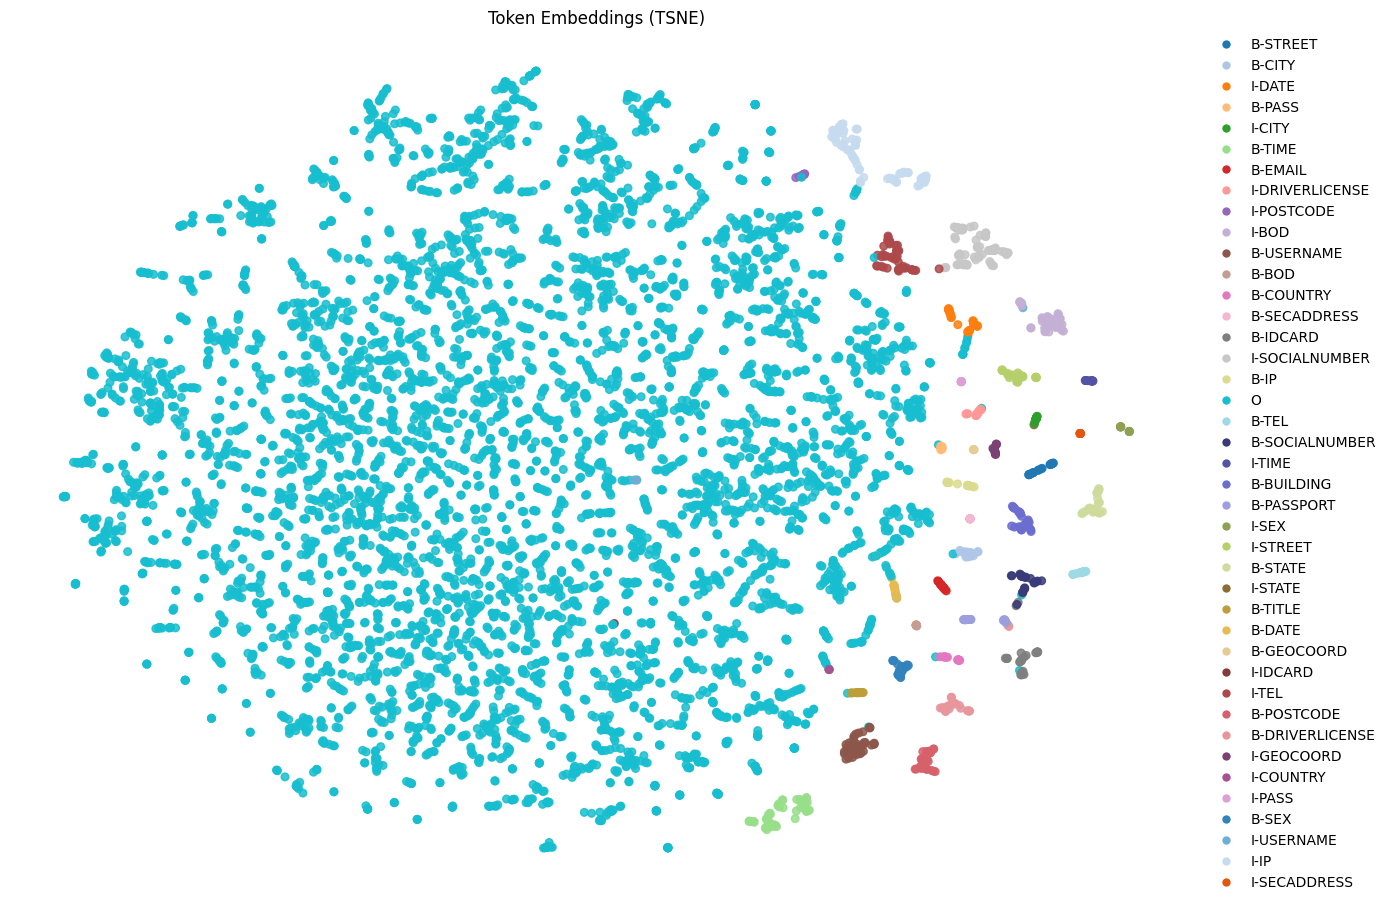

In [7]:
# 5.  Down-sample so the 2-D projector doesn’t choke
MAX_PLOT = 10000
if len(all_tok) > MAX_PLOT:
    rng  = np.random.default_rng(0)
    keep = rng.choice(len(all_tok), MAX_PLOT, replace=False)
    all_emb = np.asarray(all_emb)[keep]
    all_tok = [all_tok[i] for i in keep]
    all_lbl = [all_lbl[i] for i in keep]

# 1. build the colour palette keyed by ids
palette = build_palette(aux.id2label)   # {0:'#1f77b4', 1:'#ff7f0e', …}

plot_emb, plot_tok, plot_lbl = zip(*[
    (e, t, l)
    for e, t, l in zip(all_emb, all_tok, all_lbl)
    if l != -100                       # keep only true labels
])

visualize_embeddings_2d(
    embeddings   = np.vstack(plot_emb),
    tokens       = list(plot_tok),
    token_labels = list(plot_lbl),     # pure, valid ids
    id2label     = aux.id2label,
    palette      = palette,
    show_labels  = False,
    legend       = True,
    method="tsne"
)

In [8]:
model.eval()
all_tok, all_emb, flat_gold, flat_pred = [], [], [], []

for d in tqdm(dataset, desc="Embedding + Prediction"):
    # Step 1: reconstruct the sentence
    sentence = d["source_text"]

    # Step 2: extract embeddings and tokens
    emb, tokens = extract_distilbert_embeddings(model, tokenizer, sentence)

    # Step 3: classifier prediction
    inputs = tokenizer(sentence, return_tensors="pt")
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    with torch.no_grad():
        logits = model(**inputs).logits
        preds = logits.argmax(-1).squeeze(0).tolist()

    # Step 4: keep only tokens with real labels
    labels = d["labels"]
    for i, (tok, e, g, p) in enumerate(zip(tokens, emb, labels, preds)):
        if g == -100:
            continue
        all_tok.append(tok)
        all_emb.append(e.cpu().numpy())
        flat_gold.append(g)
        flat_pred.append(p)

Embedding + Prediction: 100%|██████████| 18244/18244 [02:18<00:00, 131.62it/s]


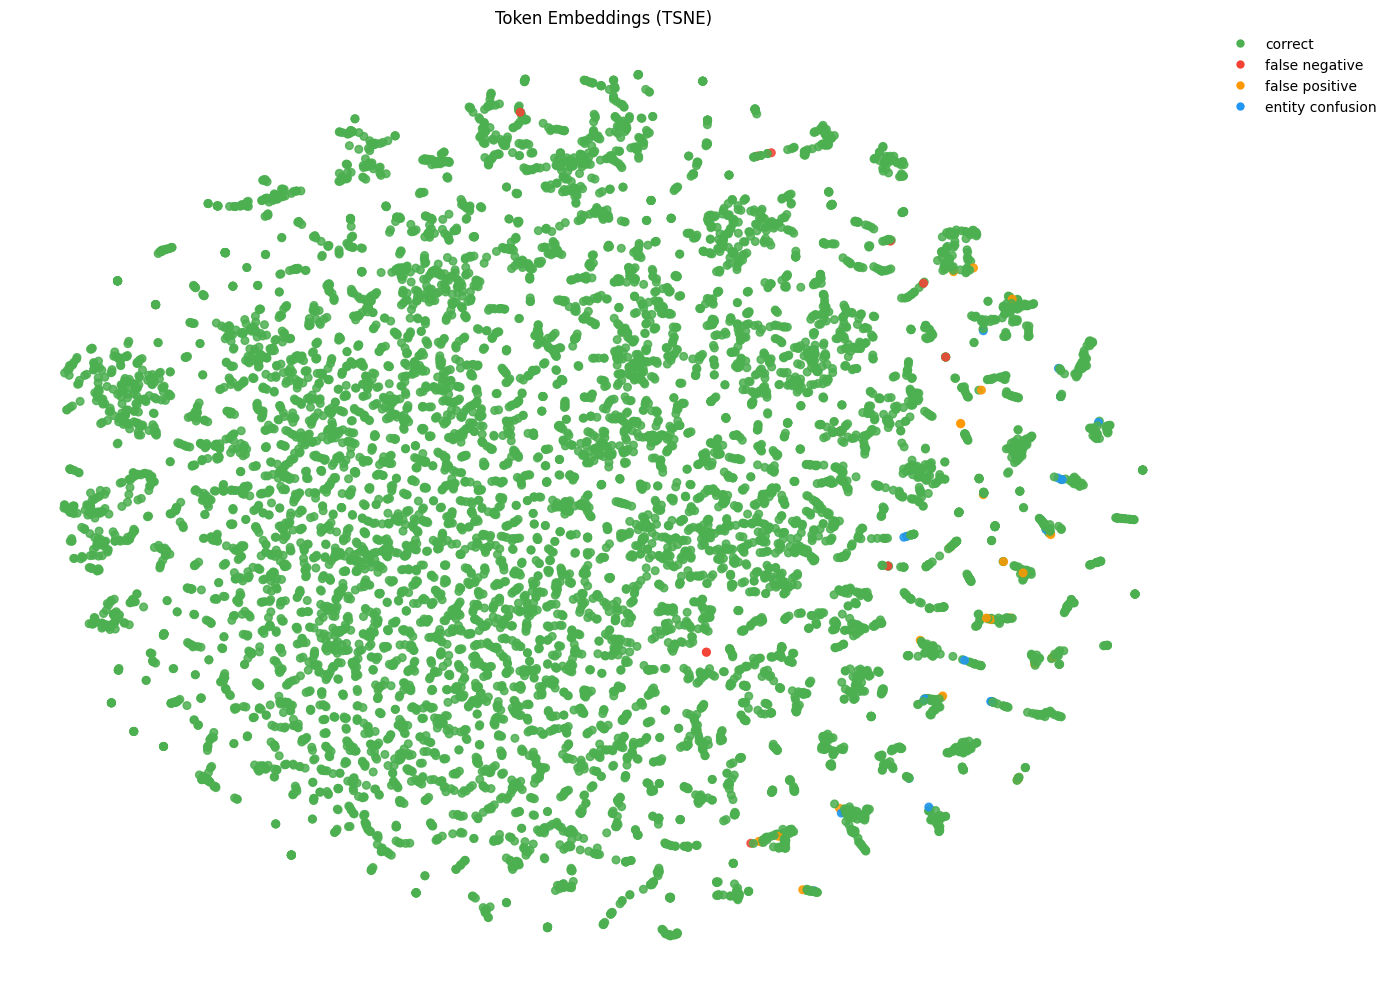

In [10]:
MAX_TSNE_POINTS = 10_000

if len(all_emb) > MAX_TSNE_POINTS:
    rng = np.random.default_rng(seed=42)
    keep_indices = rng.choice(len(all_emb), MAX_TSNE_POINTS, replace=False)

    all_emb     = np.array(all_emb)[keep_indices]
    all_tok     = [all_tok[i] for i in keep_indices]
    flat_gold   = [flat_gold[i] for i in keep_indices]
    flat_pred   = [flat_pred[i] for i in keep_indices]

custom_palette = {
    0: "#4CAF50",    # Correct → green
    1: "#F44336",    # False Negative → red
    2: "#FF9800",    # False Positive → orange
    3: "#2196F3"     # Entity Confused → blue
}

token_labels = []
for gold, pred in zip(flat_gold, flat_pred):
    if gold == pred:
        token_labels.append(0)           # ID 0 = correct
    elif gold != label2id["O"] and pred == label2id["O"]:
        token_labels.append(1)           # FN
    elif gold == label2id["O"] and pred != label2id["O"]:
        token_labels.append(2)           # FP
    else:
        token_labels.append(3)           # confusion

id2label_error = {
    0: "correct",
    1: "false negative",
    2: "false positive",
    3: "entity confusion"
}

visualize_embeddings_2d(
    embeddings=np.vstack(all_emb),
    tokens=all_tok,
    token_labels=token_labels,
    id2label=id2label_error,
    palette=custom_palette,
    method="tsne",
    show_labels=False,
    legend=True
)

In [11]:
filtered_gold = []
filtered_pred = []

for g, p in zip(flat_gold, flat_pred):
    if g != -100:
        filtered_gold.append(g)
        filtered_pred.append(p)

In [ ]:
# Use your label set
label_ids   = sorted(set(filtered_gold + filtered_pred))
label_names = [aux.id2label[i] for i in label_ids]

# Compute matrix
cm = confusion_matrix(filtered_gold, filtered_pred, labels=label_ids)

# Wrap into DataFrame
cm_df = pd.DataFrame(cm, index=label_names, columns=label_names)

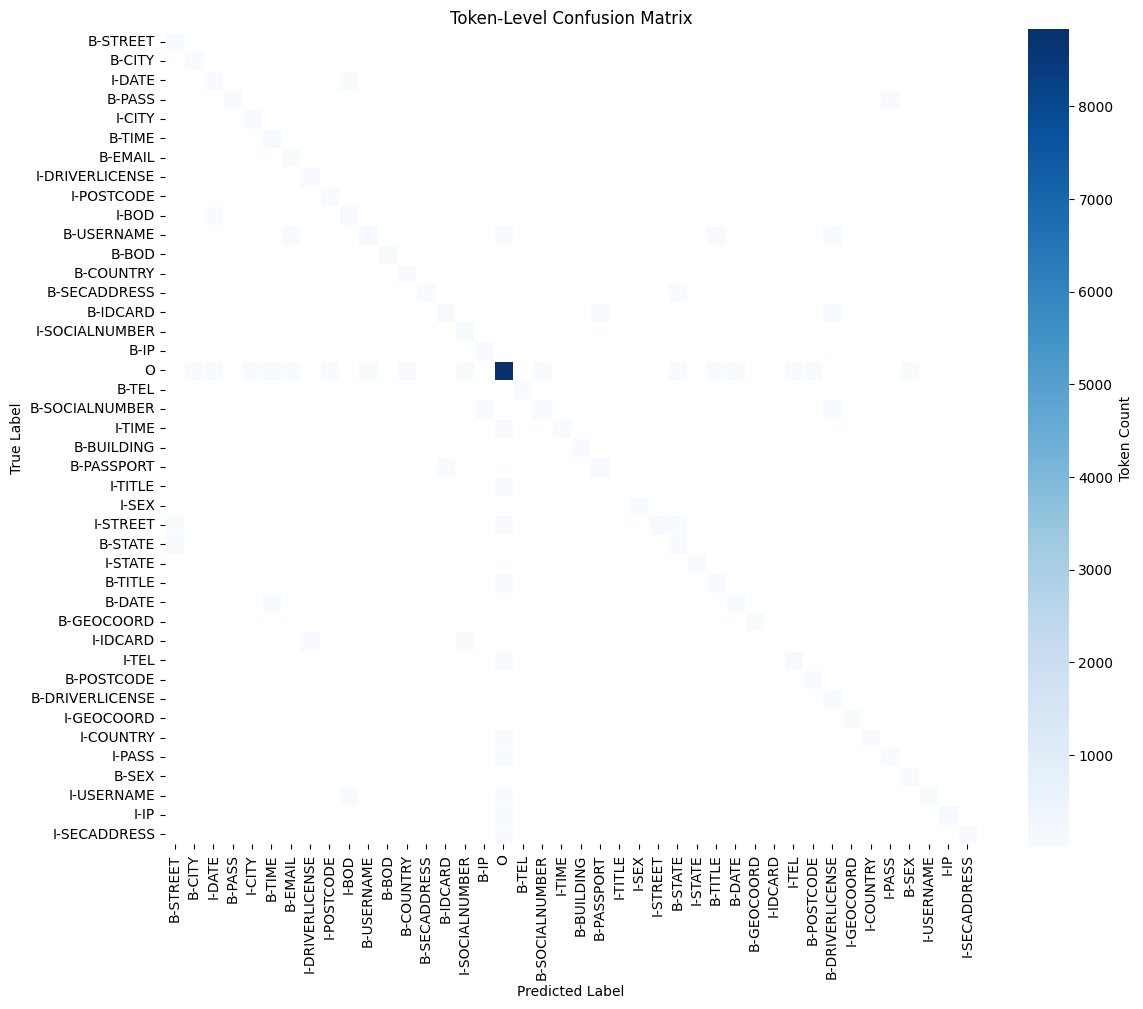

In [13]:
plt.figure(figsize=(12, 10))
sns.heatmap(cm_df, annot=False, fmt="d", cmap="Blues", linewidths=.5, square=True,
            cbar_kws={'label': 'Token Count'}, mask=(cm_df == 0))

plt.title("Token-Level Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [14]:
# Clean labels (skip -100)
filtered_gold = [g for g, p in zip(flat_gold, flat_pred) if g != -100]
filtered_pred = [p for g, p in zip(flat_gold, flat_pred) if g != -100]

label_ids = sorted(set(filtered_gold + filtered_pred))
label_names = [aux.id2label[i] for i in label_ids]

# Print full report
print(classification_report(
    filtered_gold,
    filtered_pred,
    labels=label_ids,
    target_names=label_names,
    digits=3
))


                 precision    recall  f1-score   support

       B-STREET      0.923     1.000     0.960        24
         B-CITY      0.929     1.000     0.963        26
         I-DATE      0.938     0.968     0.952        31
         B-PASS      1.000     0.857     0.923        21
         I-CITY      0.895     1.000     0.944        17
         B-TIME      0.964     1.000     0.982        54
        B-EMAIL      0.912     1.000     0.954        31
I-DRIVERLICENSE      0.967     1.000     0.983        29
     I-POSTCODE      0.941     1.000     0.970        16
          I-BOD      0.962     0.980     0.971        51
     B-USERNAME      0.953     0.891     0.921        46
          B-BOD      1.000     1.000     1.000        38
      B-COUNTRY      0.944     1.000     0.971        17
   B-SECADDRESS      1.000     0.875     0.933         8
       B-IDCARD      0.975     0.929     0.951        42
 I-SOCIALNUMBER      0.975     1.000     0.987        78
           B-IP      0.971    

c:\Users\samue\Desktop\nlp-project\cubo_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\samue\Desktop\nlp-project\cubo_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\samue\Desktop\nlp-project\cubo_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

# Distilbert 2

C:\Users\samue\AppData\Local\Temp\ipykernel_9860\1226622395.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmaps = [cm.get_cmap(name, 20) for name in ("tab20", "tab20b", "tab20c")]


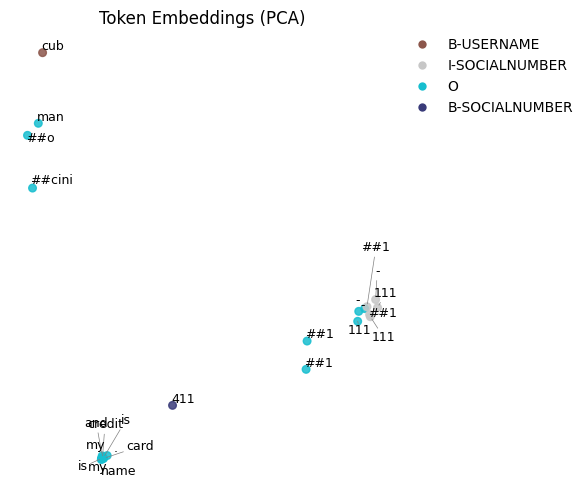

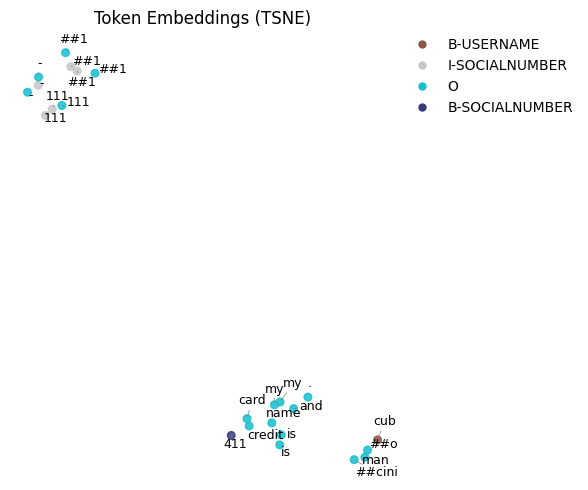

c:\Users\samue\Desktop\nlp-project\cubo_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\samue\Desktop\nlp-project\cubo_env\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


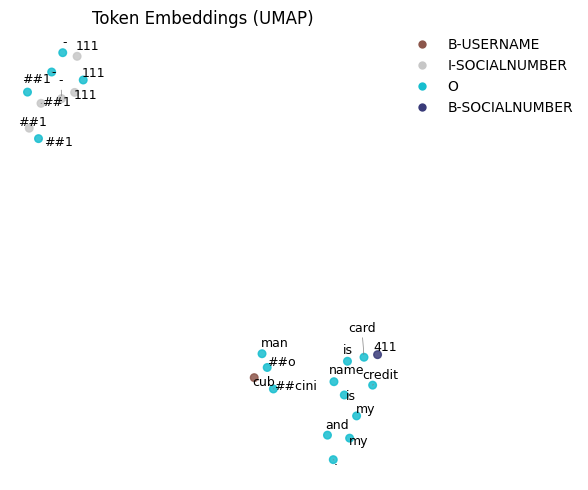

In [21]:
hidden_states, tokens = extract_distilbert_embeddings(distilbert2, tokenizer_distilbert2, test_sentence)
filtered_tok, filtered_emb, filtered_lbl = [], [], []   # we’ll fill lbl below
special = {tokenizer_distilbert2.cls_token, tokenizer_distilbert2.sep_token, tokenizer_distilbert2.pad_token}

for i, tok in enumerate(tokens):
    if tok in special:
        continue
    filtered_tok.append(tok)
    filtered_emb.append(hidden_states[i].cpu().numpy())

# ---------------------------------------------------------------------------------
# 2.  Predicted BIO label for each token (classification head)
# ---------------------------------------------------------------------------------
# Note: we reuse the *same* input_ids we just built inside extract_distilbert_embeddings
inputs       = tokenizer_distilbert2(test_sentence, return_tensors="pt")
inputs       = {k: v.to(distilbert2.device) for k, v in inputs.items()}

with torch.no_grad():
    logits   = distilbert2(**inputs).logits             # (1, seq_len, n_labels)
    preds    = logits.argmax(-1).squeeze(0)       # (seq_len,)

# Filter the predictions to line up with `filtered_tok`
for i, tok in enumerate(tokens):
    if tok in special:
        continue
    filtered_lbl.append(preds[i].item())          # int label id

# ---------------------------------------------------------------------------------
# 3.  Visualise
# ---------------------------------------------------------------------------------
palette = build_palette(aux.id2label)             # 47-colour palette

visualize_embeddings_2d(
    embeddings     = np.vstack(filtered_emb),     # (n_tokens, 768)
    tokens         = filtered_tok,                # list[str]
    token_labels   = filtered_lbl,                # list[int]
    id2label       = aux.id2label,                # dict[int->str]
    palette        = palette,
    method         = "pca",                       # or "umap"/"tsne"
    show_labels    = True,                        # small sentence → safe
    use_adjusttext = True,                        # keeps text readable
    legend         = True,
    figsize=(6,5)
)

visualize_embeddings_2d(
    embeddings     = np.vstack(filtered_emb),     # (n_tokens, 768)
    tokens         = filtered_tok,                # list[str]
    token_labels   = filtered_lbl,                # list[int]
    id2label       = aux.id2label,                # dict[int->str]
    palette        = palette,
    method         = "tsne",                       # or "umap"/"tsne"
    show_labels    = True,                        # small sentence → safe
    use_adjusttext = True,                        # keeps text readable
    legend         = True,
    figsize=(6,5)
)

visualize_embeddings_2d(
    embeddings     = np.vstack(filtered_emb),     # (n_tokens, 768)
    tokens         = filtered_tok,                # list[str]
    token_labels   = filtered_lbl,                # list[int]
    id2label       = aux.id2label,                # dict[int->str]
    palette        = palette,
    method         = "umap",                       # or "umap"/"tsne"
    show_labels    = True,                        # small sentence → safe
    use_adjusttext = True,                        # keeps text readable
    legend         = True,
    figsize=(6,5)
)

In [23]:
train_json = "data/distilbert_train.json"        
test_json = "data/distilbert_test.json"          
dataset    = aux.json_to_Dataset(train_json)
test_dataset    = aux.json_to_Dataset(test_json)

model_name = "to_share/distilbert2"
model      = AutoModelForTokenClassification.from_pretrained(model_name).to(device).eval()
tokenizer  = AutoTokenizer.from_pretrained(model_name)

In [24]:
# Collator that pads numeric tensors but leaves ragged lists intact

def collate_tok_clf(batch, pad_to_multiple_of=None):
    """
    - Pads input_ids / attention_mask via the tokenizer.
    - Keeps 'tokens' and 'labels' as raw Python lists (ragged).
    """
    numeric = [
        {k: sample[k] for k in ("input_ids", "attention_mask")}
        for sample in batch
    ]

    padded = tokenizer.pad(
        numeric,
        padding="longest",
        return_tensors="pt",
        pad_to_multiple_of=pad_to_multiple_of
    )

    # attach the ragged fields unchanged
    padded["tokens"] = [sample["tokens"]  for sample in batch]
    padded["labels"] = [sample["labels"]  for sample in batch]
    return padded

loader = DataLoader(
    dataset,
    batch_size=32,                 # ↓ if you get CUDA-OOM
    shuffle=False,
    collate_fn=collate_tok_clf
)

# 4.  Harvest hidden-state vectors for every non-special token
all_tok, all_emb, all_lbl = [], [], []

with torch.no_grad():
    for batch in tqdm(loader, desc="Embedding → GPU"):
        ids  = batch["input_ids"].to(device)
        mask = batch["attention_mask"].to(device)

        # Forward through the *encoder* only
        h = model.distilbert(input_ids=ids, attention_mask=mask).last_hidden_state
        h = h.cpu().numpy()                       # move off-GPU right away

        for seq_idx, (toks, labs) in enumerate(zip(batch["tokens"], batch["labels"])):
            for pos, tok in enumerate(toks):
                if tok in {tokenizer.cls_token, tokenizer.sep_token, tokenizer.pad_token}:
                    continue
                all_tok.append(tok)
                all_emb.append(h[seq_idx, pos])
                all_lbl.append(labs[pos])

Embedding → GPU: 100%|██████████| 571/571 [00:57<00:00,  9.94it/s]


C:\Users\samue\AppData\Local\Temp\ipykernel_9860\1226622395.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmaps = [cm.get_cmap(name, 20) for name in ("tab20", "tab20b", "tab20c")]


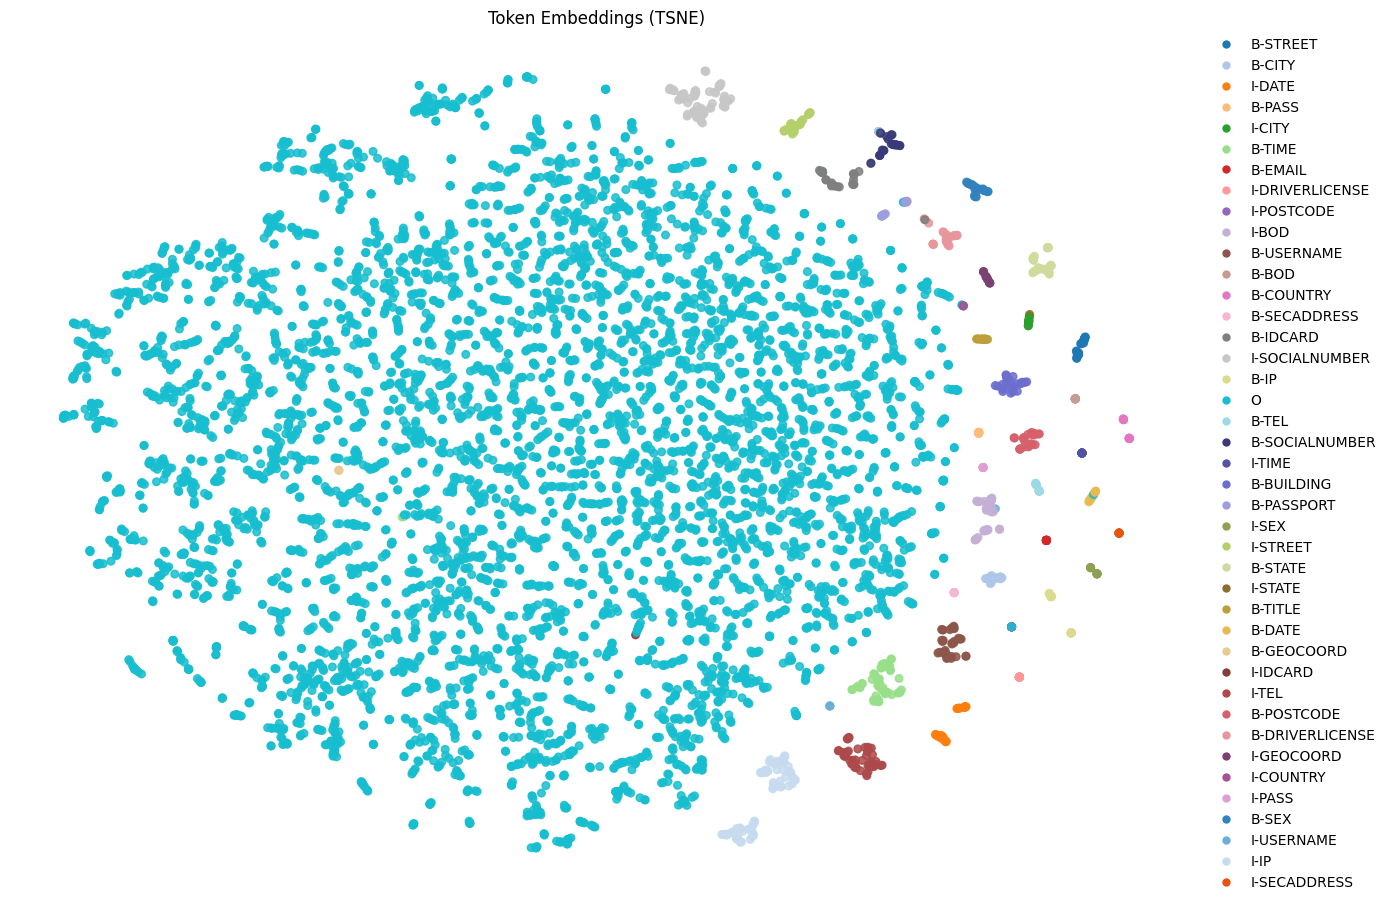

In [25]:
# 5.  Down-sample so the 2-D projector doesn’t choke
MAX_PLOT = 10000
if len(all_tok) > MAX_PLOT:
    rng  = np.random.default_rng(0)
    keep = rng.choice(len(all_tok), MAX_PLOT, replace=False)
    all_emb = np.asarray(all_emb)[keep]
    all_tok = [all_tok[i] for i in keep]
    all_lbl = [all_lbl[i] for i in keep]

# 1. build the colour palette keyed by ids
palette = build_palette(aux.id2label)   # {0:'#1f77b4', 1:'#ff7f0e', …}

plot_emb, plot_tok, plot_lbl = zip(*[
    (e, t, l)
    for e, t, l in zip(all_emb, all_tok, all_lbl)
    if l != -100                       # keep only true labels
])

visualize_embeddings_2d(
    embeddings   = np.vstack(plot_emb),
    tokens       = list(plot_tok),
    token_labels = list(plot_lbl),     # pure, valid ids
    id2label     = aux.id2label,
    palette      = palette,
    show_labels  = False,
    legend       = True,
    method="tsne"
)

In [26]:
model.eval()
all_tok, all_emb, flat_gold, flat_pred = [], [], [], []

for d in tqdm(dataset, desc="Embedding + Prediction"):
    # Step 1: reconstruct the sentence
    sentence = d["source_text"]

    # Step 2: extract embeddings and tokens
    emb, tokens = extract_distilbert_embeddings(model, tokenizer, sentence)

    # Step 3: classifier prediction
    inputs = tokenizer(sentence, return_tensors="pt")
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    with torch.no_grad():
        logits = model(**inputs).logits
        preds = logits.argmax(-1).squeeze(0).tolist()

    # Step 4: keep only tokens with real labels
    labels = d["labels"]
    for i, (tok, e, g, p) in enumerate(zip(tokens, emb, labels, preds)):
        if g == -100:
            continue
        all_tok.append(tok)
        all_emb.append(e.cpu().numpy())
        flat_gold.append(g)
        flat_pred.append(p)

Embedding + Prediction: 100%|██████████| 18244/18244 [02:38<00:00, 115.37it/s]


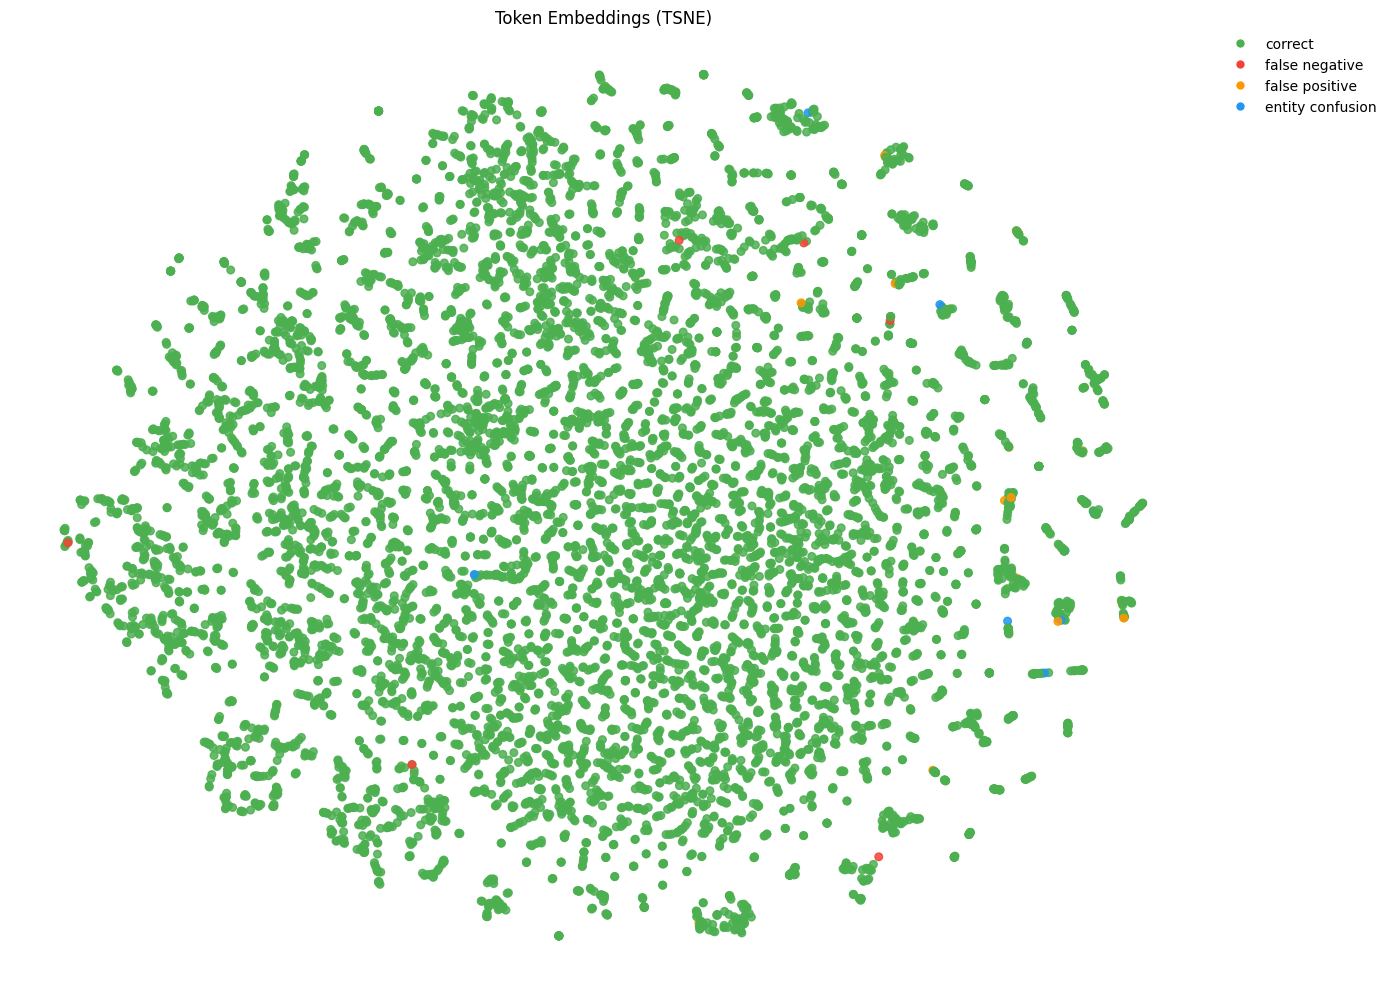

In [27]:
MAX_TSNE_POINTS = 10_000

if len(all_emb) > MAX_TSNE_POINTS:
    rng = np.random.default_rng(seed=42)
    keep_indices = rng.choice(len(all_emb), MAX_TSNE_POINTS, replace=False)

    all_emb     = np.array(all_emb)[keep_indices]
    all_tok     = [all_tok[i] for i in keep_indices]
    flat_gold   = [flat_gold[i] for i in keep_indices]
    flat_pred   = [flat_pred[i] for i in keep_indices]

custom_palette = {
    0: "#4CAF50",    # Correct → green
    1: "#F44336",    # False Negative → red
    2: "#FF9800",    # False Positive → orange
    3: "#2196F3"     # Entity Confused → blue
}

token_labels = []
for gold, pred in zip(flat_gold, flat_pred):
    if gold == pred:
        token_labels.append(0)           # ID 0 = correct
    elif gold != label2id["O"] and pred == label2id["O"]:
        token_labels.append(1)           # FN
    elif gold == label2id["O"] and pred != label2id["O"]:
        token_labels.append(2)           # FP
    else:
        token_labels.append(3)           # confusion

id2label_error = {
    0: "correct",
    1: "false negative",
    2: "false positive",
    3: "entity confusion"
}

visualize_embeddings_2d(
    embeddings=np.vstack(all_emb),
    tokens=all_tok,
    token_labels=token_labels,
    id2label=id2label_error,
    palette=custom_palette,
    method="tsne",
    show_labels=False,
    legend=True
)

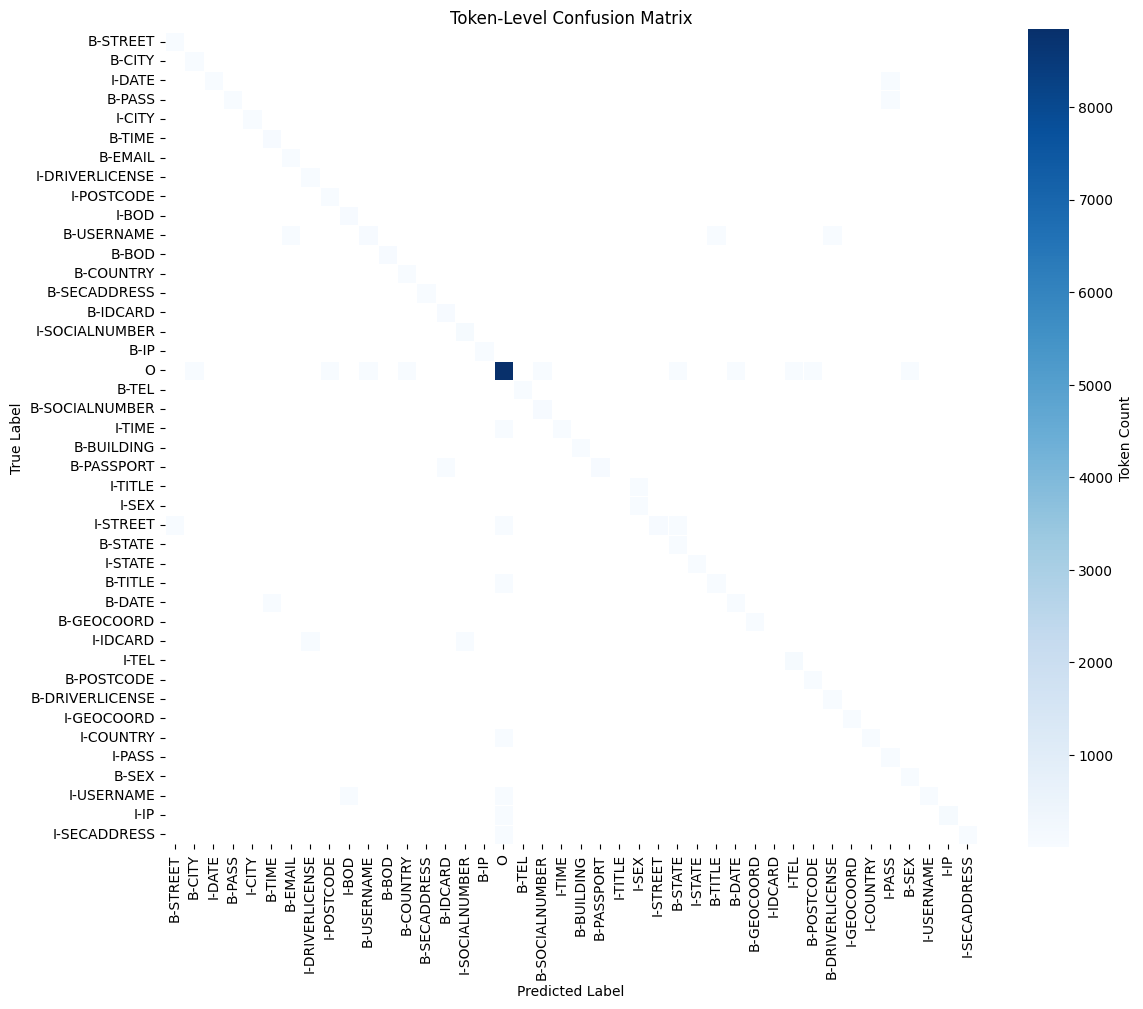

In [47]:
plt.figure(figsize=(12, 10))
sns.heatmap(cm_df, annot=False, fmt="d", cmap="Blues", linewidths=.5, square=True,
            cbar_kws={'label': 'Token Count'}, mask=(cm_df == 0))

plt.title("Token-Level Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [48]:
# Use your label set
label_ids   = sorted(set(filtered_gold + filtered_pred))
label_names = [aux.id2label[i] for i in label_ids]

# Compute matrix
cm = confusion_matrix(filtered_gold, filtered_pred, labels=label_ids)

# Wrap into DataFrame
cm_df = pd.DataFrame(cm, index=label_names, columns=label_names)

In [49]:
# Clean labels (skip -100)
filtered_gold = [g for g, p in zip(flat_gold, flat_pred) if g != -100]
filtered_pred = [p for g, p in zip(flat_gold, flat_pred) if g != -100]

label_ids = sorted(set(filtered_gold + filtered_pred))
label_names = [aux.id2label[i] for i in label_ids]

# Print full report
print(classification_report(
    filtered_gold,
    filtered_pred,
    labels=label_ids,\
    target_names=label_names,
    digits=3
))


                 precision    recall  f1-score   support

       B-STREET      0.960     1.000     0.980        24
         B-CITY      0.929     1.000     0.963        26
         I-DATE      1.000     0.968     0.984        31
         B-PASS      1.000     0.905     0.950        21
         I-CITY      1.000     1.000     1.000        17
         B-TIME      0.982     1.000     0.991        54
        B-EMAIL      0.939     1.000     0.969        31
I-DRIVERLICENSE      0.967     1.000     0.983        29
     I-POSTCODE      0.889     1.000     0.941        16
          I-BOD      0.981     1.000     0.990        51
     B-USERNAME      0.953     0.891     0.921        46
          B-BOD      1.000     1.000     1.000        38
      B-COUNTRY      0.944     1.000     0.971        17
   B-SECADDRESS      1.000     1.000     1.000         8
       B-IDCARD      0.977     1.000     0.988        42
 I-SOCIALNUMBER      0.987     1.000     0.994        78
           B-IP      1.000    

c:\Users\samue\Desktop\nlp-project\cubo_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\samue\Desktop\nlp-project\cubo_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\samue\Desktop\nlp-project\cubo_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

# Albert1

C:\Users\samue\AppData\Local\Temp\ipykernel_9860\1060686878.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmaps = [cm.get_cmap(name, 20) for name in ("tab20", "tab20b", "tab20c")]


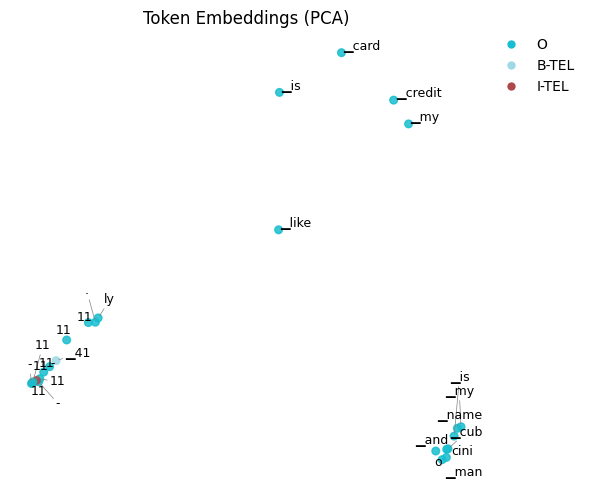

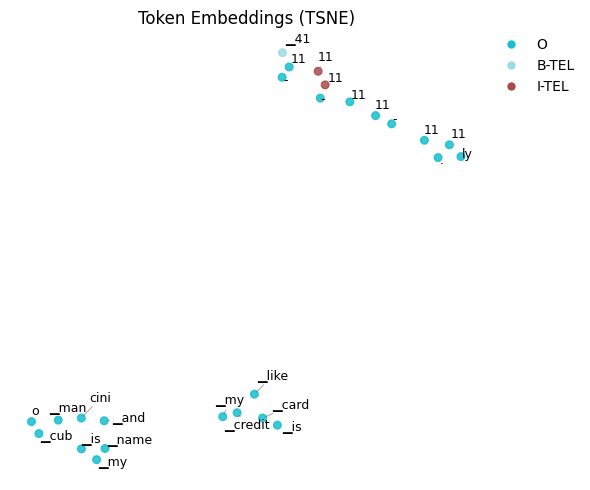

c:\Users\samue\Desktop\nlp-project\cubo_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\samue\Desktop\nlp-project\cubo_env\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


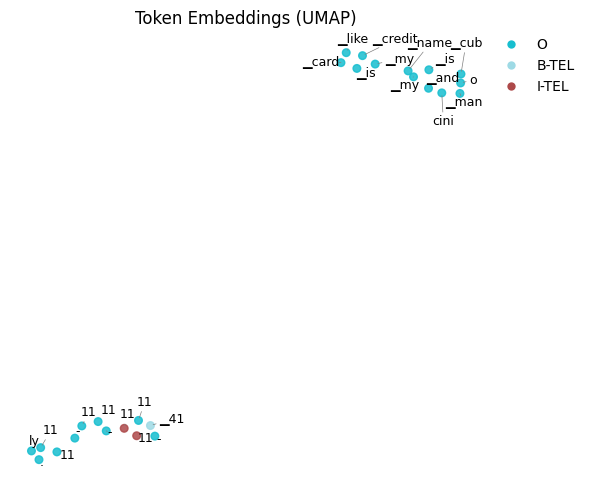

In [40]:
hidden_states, tokens = extract_albert_embeddings(albert1, tokenizer_albert1, test_sentence)
filtered_tok, filtered_emb, filtered_lbl = [], [], []   # we’ll fill lbl below
special = {tokenizer_albert1.cls_token, tokenizer_albert1.sep_token, tokenizer_albert1.pad_token}

for i, tok in enumerate(tokens):
    if tok in special:
        continue
    filtered_tok.append(tok)
    filtered_emb.append(hidden_states[i].cpu().numpy())

# ---------------------------------------------------------------------------------
# 2.  Predicted BIO label for each token (classification head)
# ---------------------------------------------------------------------------------
# Note: we reuse the *same* input_ids we just built inside extract_distilbert_embeddings
inputs       = tokenizer_albert1(test_sentence, return_tensors="pt")
inputs       = {k: v.to(albert1.device) for k, v in inputs.items()}

with torch.no_grad():
    logits   = albert1(**inputs).logits             # (1, seq_len, n_labels)
    preds    = logits.argmax(-1).squeeze(0)       # (seq_len,)

# Filter the predictions to line up with `filtered_tok`
for i, tok in enumerate(tokens):
    if tok in special:
        continue
    filtered_lbl.append(preds[i].item())          # int label id

# ---------------------------------------------------------------------------------
# 3.  Visualise
# ---------------------------------------------------------------------------------
palette = build_palette(aux.id2label)             # 47-colour palette

visualize_embeddings_2d(
    embeddings     = np.vstack(filtered_emb),     # (n_tokens, 768)
    tokens         = filtered_tok,                # list[str]
    token_labels   = filtered_lbl,                # list[int]
    id2label       = aux.id2label,                # dict[int->str]
    palette        = palette,
    method         = "pca",                       # or "umap"/"tsne"
    show_labels    = True,                        # small sentence → safe
    use_adjusttext = True,                        # keeps text readable
    legend         = True,
    figsize=(6,5)
)

visualize_embeddings_2d(
    embeddings     = np.vstack(filtered_emb),     # (n_tokens, 768)
    tokens         = filtered_tok,                # list[str]
    token_labels   = filtered_lbl,                # list[int]
    id2label       = aux.id2label,                # dict[int->str]
    palette        = palette,
    method         = "tsne",                       # or "umap"/"tsne"
    show_labels    = True,                        # small sentence → safe
    use_adjusttext = True,                        # keeps text readable
    legend         = True,
    figsize=(6,5)
)

visualize_embeddings_2d(
    embeddings     = np.vstack(filtered_emb),     # (n_tokens, 768)
    tokens         = filtered_tok,                # list[str]
    token_labels   = filtered_lbl,                # list[int]
    id2label       = aux.id2label,                # dict[int->str]
    palette        = palette,
    method         = "umap",                       # or "umap"/"tsne"
    show_labels    = True,                        # small sentence → safe
    use_adjusttext = True,                        # keeps text readable
    legend         = True,
    figsize=(6,5)
)

In [42]:
train_json = "data/albert_train.json"        
test_json = "data/albert_test.json"          
dataset    = aux.json_to_Dataset(train_json)
test_dataset    = aux.json_to_Dataset(test_json)

model_name = "to_share/albert1"
model      = AutoModelForTokenClassification.from_pretrained(model_name).to(device).eval()
tokenizer  = AutoTokenizer.from_pretrained(model_name)

In [44]:
# Collator that pads numeric tensors but leaves ragged lists intact

def collate_tok_clf(batch, pad_to_multiple_of=None):
    """
    - Pads input_ids / attention_mask via the tokenizer.
    - Keeps 'tokens' and 'labels' as raw Python lists (ragged).
    """
    numeric = [
        {k: sample[k] for k in ("input_ids", "attention_mask")}
        for sample in batch
    ]

    padded = tokenizer.pad(
        numeric,
        padding="longest",
        return_tensors="pt",
        pad_to_multiple_of=pad_to_multiple_of
    )

    # attach the ragged fields unchanged
    padded["tokens"] = [sample["tokens"]  for sample in batch]
    padded["labels"] = [sample["labels"]  for sample in batch]
    return padded

loader = DataLoader(
    dataset,
    batch_size=32,                 # ↓ if you get CUDA-OOM
    shuffle=False,
    collate_fn=collate_tok_clf
)

# 4.  Harvest hidden-state vectors for every non-special token
all_tok, all_emb, all_lbl = [], [], []

with torch.no_grad():
    for batch in tqdm(loader, desc="Embedding → GPU"):
        ids  = batch["input_ids"].to(device)
        mask = batch["attention_mask"].to(device)

        # Forward through the *encoder* only
        h = model.albert(input_ids=ids, attention_mask=mask).last_hidden_state
        h = h.cpu().numpy()                       # move off-GPU right away

        for seq_idx, (toks, labs) in enumerate(zip(batch["tokens"], batch["labels"])):
            for pos, tok in enumerate(toks):
                if tok in {tokenizer.cls_token, tokenizer.sep_token, tokenizer.pad_token}:
                    continue
                all_tok.append(tok)
                all_emb.append(h[seq_idx, pos])
                all_lbl.append(labs[pos])

Embedding → GPU: 100%|██████████| 571/571 [02:58<00:00,  3.20it/s]


C:\Users\samue\AppData\Local\Temp\ipykernel_9860\1060686878.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmaps = [cm.get_cmap(name, 20) for name in ("tab20", "tab20b", "tab20c")]


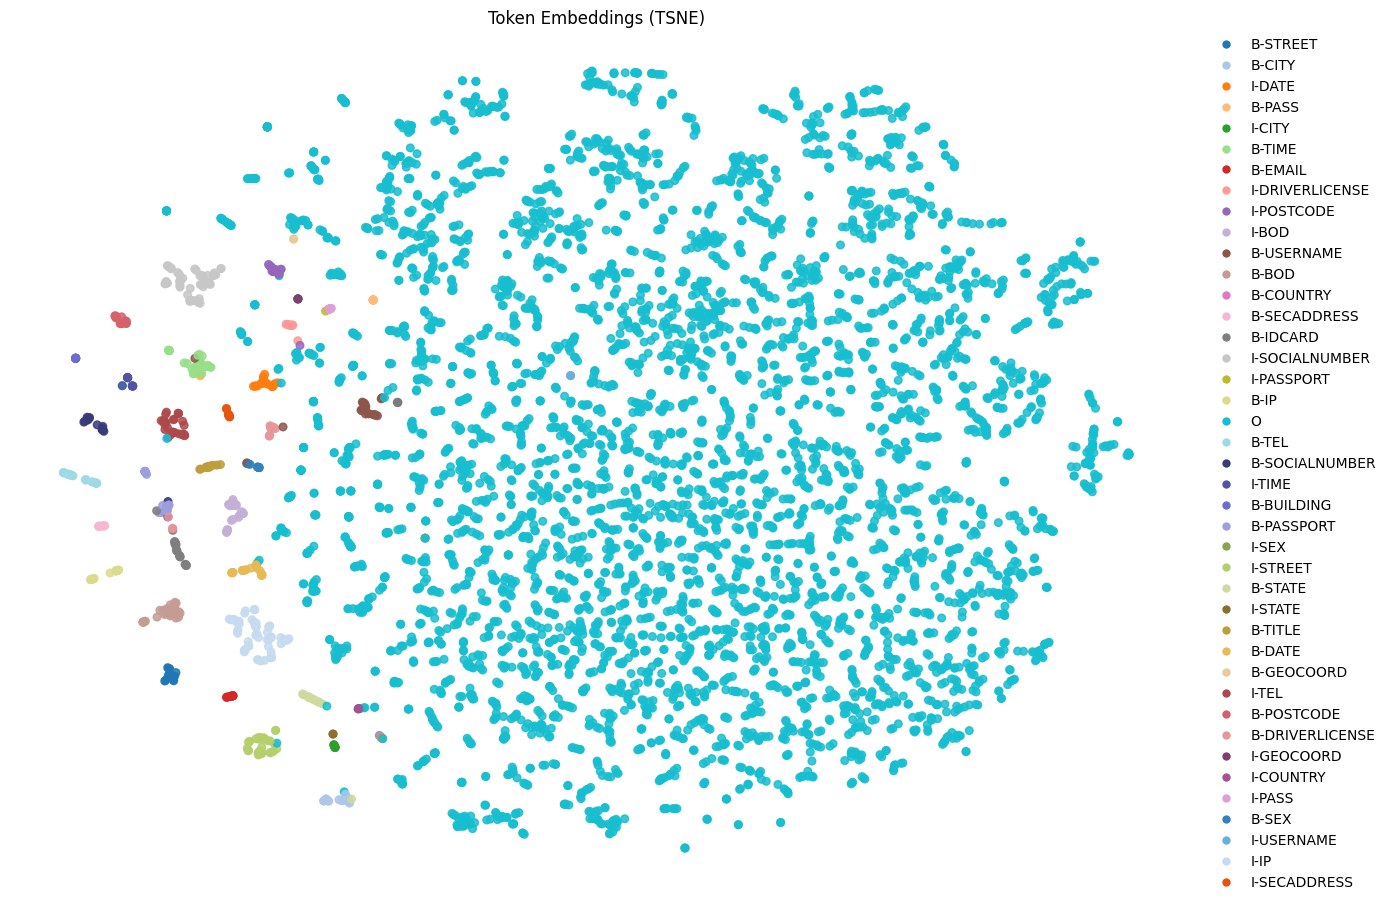

In [45]:
# 5.  Down-sample so the 2-D projector doesn’t choke
MAX_PLOT = 10000
if len(all_tok) > MAX_PLOT:
    rng  = np.random.default_rng(0)
    keep = rng.choice(len(all_tok), MAX_PLOT, replace=False)
    all_emb = np.asarray(all_emb)[keep]
    all_tok = [all_tok[i] for i in keep]
    all_lbl = [all_lbl[i] for i in keep]

# 1. build the colour palette keyed by ids
palette = build_palette(aux.id2label)   # {0:'#1f77b4', 1:'#ff7f0e', …}

plot_emb, plot_tok, plot_lbl = zip(*[
    (e, t, l)
    for e, t, l in zip(all_emb, all_tok, all_lbl)
    if l != -100                       # keep only true labels
])

visualize_embeddings_2d(
    embeddings   = np.vstack(plot_emb),
    tokens       = list(plot_tok),
    token_labels = list(plot_lbl),     # pure, valid ids
    id2label     = aux.id2label,
    palette      = palette,
    show_labels  = False,
    legend       = True,
    method="tsne"
)

In [ ]:
# 5.  Down-sample so the 2-D projector doesn’t choke
MAX_PLOT = 10000
if len(all_tok) > MAX_PLOT:
    rng  = np.random.default_rng(0)
    keep = rng.choice(len(all_tok), MAX_PLOT, replace=False)
    all_emb = np.asarray(all_emb)[keep]
    all_tok = [all_tok[i] for i in keep]
    all_lbl = [all_lbl[i] for i in keep]

# 1. build the colour palette keyed by ids
palette = build_palette(aux.id2label)   # {0:'#1f77b4', 1:'#ff7f0e', …}

plot_emb, plot_tok, plot_lbl = zip(*[
    (e, t, l)
    for e, t, l in zip(all_emb, all_tok, all_lbl)
    if l != -100                       # keep only true labels
])

visualize_embeddings_2d(
    embeddings   = np.vstack(plot_emb),
    tokens       = list(plot_tok),
    token_labels = list(plot_lbl),     # pure, valid ids
    id2label     = aux.id2label,
    palette      = palette,
    show_labels  = False,
    legend       = True,
    method="tsne"
)

In [ ]:
model.eval()
all_tok, all_emb, flat_gold, flat_pred = [], [], [], []

for d in tqdm(dataset, desc="Embedding + Prediction"):
    # Step 1: reconstruct the sentence
    sentence = d["source_text"]

    # Step 2: extract embeddings and tokens
    emb, tokens = extract_albert_embeddings(model, tokenizer, sentence)

    # Step 3: classifier prediction
    inputs = tokenizer(sentence, return_tensors="pt")
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    with torch.no_grad():
        logits = model(**inputs).logits
        preds = logits.argmax(-1).squeeze(0).tolist()

    # Step 4: keep only tokens with real labels
    labels = d["labels"]
    for i, (tok, e, g, p) in enumerate(zip(tokens, emb, labels, preds)):
        if g == -100:
            continue
        all_tok.append(tok)
        all_emb.append(e.cpu().numpy())
        flat_gold.append(g)
        flat_pred.append(p)